### Import Dependencies

In [3]:
import csv           #for read write csv file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load CSV Data

In [4]:
df = pd.read_csv(r'water_data.csv')
array = np.array(df)

#delete redundent column and check data
#each column represents the following water data: 
#index, date, time, water temperature, pH, dissolve oxygen (DO), and electrical conductivity (EC)
data = array[:,0:7]
data.shape

(4273, 7)

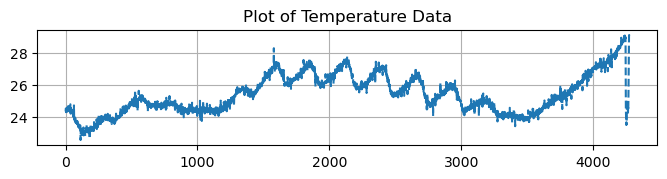

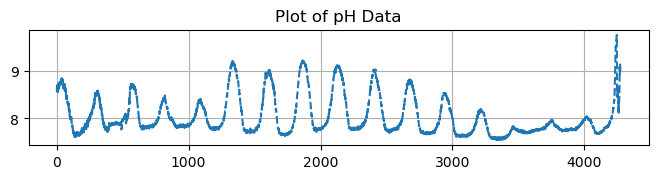

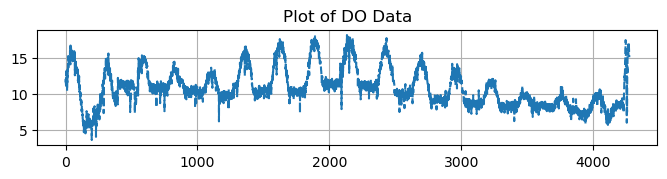

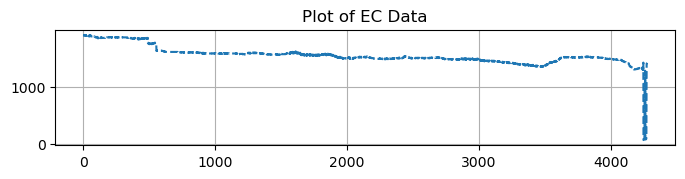

In [5]:
#Plot the datas and have a look
data_names = ["Temperature", "pH", "DO", "EC"]
for i in range(len(data_names)):
    plt.figure(figsize=(8, 1.5))
    plt.title('Raw Data')
    plt.plot(np.transpose(data[:,0]), np.transpose(data[:,i+3]), linestyle='--')
    # plt.xticks(rotation=45)
    plt.title("Plot of " + data_names[i] + " Data")
    plt.grid()
    plt.show()

### Z-Normalize Data

In [63]:
#first, we are only interested in water parameter datas, which are column 3 to 6
water_data = data[0:4000,3:7]

#define empty array for putting normalized water data
water_data_norm = np.zeros(water_data.shape)

#define empty array for mean and variance
water_data_var = np.zeros(water_data.shape[1])
water_data_mean = np.zeros(water_data.shape[1])


data_names = ["Temperature", "pH", "DO", "EC"]
z_normalizing_constant = {name : {} for name in data_names}

#carryout normalization by each column
for i in range(water_data.shape[1]):
    # calculate mean and variance for each data column
    water_data_var[i] = np.var(water_data[:,i])
    water_data_mean[i] = np.mean(water_data[:,i])

    # record mean and variance of water data
    name = data_names[i]
    z_normalizing_constant[name]['var'] = water_data_var[i]
    z_normalizing_constant[name]['mean'] = water_data_mean[i]

    #conduct z-normalization by subtracting sample mean and divided by standard deviation
    water_data_norm[:,i] = (water_data[:,i] - water_data_mean[i]) / np.sqrt(water_data_var[i])

np.save('normalizing_constants', z_normalizing_constant)

#now we can test our function with different 
print(np.mean(water_data_norm))   # very close to zero

1.2278178473934531e-14


In [95]:
z_normalizing_constant

{'Temperature': {'var': 1.1551278036937513, 'mean': 25.254617500000002},
 'pH': {'var': 0.16354016094374732, 'mean': 8.04423249999998},
 'DO': {'var': 6.379821424797464, 'mean': 10.969207249999997},
 'EC': {'var': 16632.41791493756, 'mean': 1556.87025}}

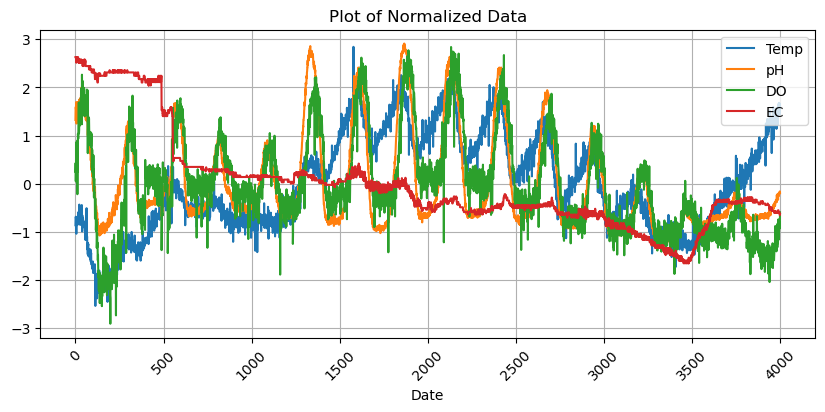

In [64]:
#Plot normalized data and have a look
plt.figure(figsize = (10,4))
plt.title('Plot of Normalized Data')
plt.xlabel('Date')
plt.ylabel('') 

plt.plot(np.transpose(water_data_norm[:,0]), linestyle='-',label='Temp')
plt.plot(np.transpose(water_data_norm[:,1]), linestyle='-',label='pH')
plt.plot(np.transpose(water_data_norm[:,2]), linestyle='-',label='DO')
plt.plot(np.transpose(water_data_norm[:,3]), linestyle='-',label='EC')
plt.xticks(rotation=45)

plt.legend(loc='upper right')
plt.grid()
plt.show()

### Fitting the model

In [97]:
# Now, we can relatively easily fit a multivariant gaussian distribution to our data as the kernel of our model.
# We first obtain the covariance matrix, which will be a constant term in the model
water_data_cov = np.cov(np.transpose(water_data_norm))


# then, we fit the maximum likelyhood multivariant gaussian PDF to given data
# note that in our test case, dimension of data = 4 (temp, pH, DO, EC)
# also, note that we should only input already z-normalized data into the function. Thus the mean of the data would be zero.

def water_mul_var_gauss(water_data_input):
    dim = water_data_input.shape[0]
    constant_term = 1/((2*np.pi)**(dim/2))
    one_over_det_sqrt = 1/np.linalg.det(water_data_cov)**(1/2)
    exponent_term = (-1/2)*np.transpose(water_data_input)@np.linalg.inv(water_data_cov)@water_data_input
    return (constant_term*one_over_det_sqrt*np.exp(exponent_term)) / 0.06004116676124076

#note that we shall define a normalizing function to normalize our input to the distribution first.
#THIS HAVE TO BE UPDATED WHEN WE UPDATE THE TRAINING DATA
def water_data_normalize(input):
    output = np.divide((input - water_data_mean),np.sqrt(water_data_var))
    return output


In [99]:
z_normalizing_constant

{'Temperature': {'var': 1.1551278036937513, 'mean': 25.254617500000002},
 'pH': {'var': 0.16354016094374732, 'mean': 8.04423249999998},
 'DO': {'var': 6.379821424797464, 'mean': 10.969207249999997},
 'EC': {'var': 16632.41791493756, 'mean': 1556.87025}}

In [104]:
### Finally, we cna define our model here:

suggestion_vector1 = np.array([1, 0, 0, 0], dtype = np.float64)    # make sure this vector has norm 1
suggestion_1 = "temperature too hot/cold"


# Given an instant of status of water:
water_state = np.array([25.25, 8, 2, 250])

# first normalize the data
water_state_norm = water_data_normalize(water_state)

# then project water status to suggestion vector
product1 = np.inner(water_state_norm, suggestion_vector1)
projection1 = product1 * suggestion_vector1

print(projection1)
# now we can evaluate such suggestion vector using multivariant gaussian model
test = water_mul_var_gauss(projection1)
test


[-0.00429627 -0.         -0.         -0.        ]


0.9999847749714452

In [76]:
water_state_norm

array([  9.06742289,  -0.10937782,  -3.55099285, -10.13339046])

### Visualisation of demo


In [ ]:
# TODO:
# Visualize distribution with 2 dimension heatmap
# make demo and compact entire thing with single function
# 

